## Part 0: Input

In [2]:
import pandas as pd
import numpy as np
import csv

In [3]:
import jieba.posseg as jp
import jieba.analyse
import jieba

from gensim import corpora

In [84]:
#Precess the data
# data = pd.read_csv('data_v3.csv',index_col = 0)
data = pd.read_csv('data_v3.csv')
data_text = data.loc[:,['aid', 'title', 'description','video_review']]
data_text.aid = data_text.aid.astype(int)
data_text_cleaned = data_text.dropna(how = 'any')

## Part 1: Pre-Processing

###### 1) tokenlize

In [8]:
flags = ('n', 'nr', 'ns', 'nt', 'ng','a', 'd', 'v') 

In [9]:
cn_stopword = [str(line.rstrip()) for line in open('cn_stopword.csv', encoding = 'UTF-8-sig')]
bili_stopword = [str(line.rstrip()) for line in open('bili_stopword.csv', encoding = 'UTF-8-sig')]
stopwords = cn_stopword + bili_stopword

import csv
with open("all_stopword.csv", "w",  newline='', encoding='utf-8-sig') as f:
    w = csv.writer(f)
    for word in stopwords:
        w.writerow([word])
    f.close()

In [10]:
# Token
def get_text(texts):
    words_list = []
    for text in texts:
        words = [w.word for w in jp.cut(text) if w.flag in flags and w.word not in stopwords]
        words_list.append(words)
    return words_list

###### 2) add customized words
note: some 'addword' will not be effective!! https://github.com/fxsjy/jieba/issues/536

In [11]:
bili_addword = [str(line.rstrip()) for line in open('bili_tokenword.csv', encoding = 'UTF-8-sig')]

In [12]:
for word in bili_addword:
    jieba.add_word(word)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\HedyHe\AppData\Local\Temp\jieba.cache
Loading model cost 1.745 seconds.
Prefix dict has been built successfully.


######  3) processing

In [14]:
words_list_desc = get_text(data_text_cleaned.description)
words_list_title = get_text(data_text_cleaned.title)

## Part 2: Models

### Model 1: LDA (Quit)
seems not useful........

In [16]:
# from gensim import models

In [17]:
# # LDA Model
# def LDA_model(words_list,num_topics=5):  
#     # Dictionary: Dictionary encapsulates the mapping between normalized words and their integer ids.
#     dictionary = corpora.Dictionary(words_list)
#     # dictionary.token2id  #look at token id
    
#     # doc2bow(): Convert `document` into the bag-of-words (BoW) format = list of `(token_id, token_count)` tuples.
#     corpus = [dictionary.doc2bow(words) for words in words_list]
 
#     # LDA主题模型。
#     # passes: Number of passes through the corpus during training.
#     lda_model = models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
 
#     return lda_model

In [ ]:
# target_topics = 5

# lda_model_desc = LDA_model(words_list_desc, target_topics)
# topics_desc = lda_model_desc.show_topics(num_topics = 5, num_words = 20)
# for topic in topics_desc:
#     print(topic)
#     print('=============================')
    
# print('\n')    
    
# lda_model_title = LDA_model(words_list_title, target_topics)
# topics_title = lda_model_title.show_topics(num_topics = 5, num_words = 20)
# for topic in topics_title:
#     print(topic)
#     print('=============================')

### Model 2: TFiDF

#### 2.1 sklearn

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [16]:
# TFIDF Model
def TFIDF_model(words_list, feature_words_count_sentence = 3, feature_words_count_all = 100):
    sentences_list = [' '.join(s) for s in words_list]
    #Convert a collection of text documents to a matrix of token counts, a[i][j] j-word i-doc
    vectorizer = CountVectorizer()
    counts_matrix = vectorizer.fit_transform(sentences_list)
    #Transform a count matrix to a normalized tf or tf-idf representation
    tf_idf_transformer = TfidfTransformer()
    tf_idf = tf_idf_transformer.fit_transform(counts_matrix)

    #Get key feature names
    words = vectorizer.get_feature_names()
    #Get Weights 
    weights = tf_idf.toarray()
            
    #get all feature words        
    feature_words_all = np.array(words)[list(np.argsort(-weights.sum(axis = 0))[:feature_words_count_all])]
    feature_weights_all = -np.sort(-weights.sum(axis = 0))[:feature_words_count_all]
    print(feature_words_all)
    print(feature_weights_all)     
    
    #print sentence feature words
#     for weight in weights:
#         # sorting
#         loc = np.argsort(-weight)
#         for i in range(feature_words_count_sentence):
#             print ('-{}: {} {}'.format(str(i + 1), words[loc[i]], weight[loc[i]]))
#         print('\n')                             


    return words, weights, feature_words_all, feature_weights_all

    # tf_idf = tf_idf_transformer.transform(vectorizer.transform(x_test))
    # x_test_weight = tf_idf.toarray()  

In [17]:
words_desc, weights_desc, feature_words_all_desc, feature_weights_all_desc = TFIDF_model(words_list_desc)

['视频' '喜欢' '美食' '好吃' '支持' '关注' '感谢' '真的' '粉丝' '做法' '简单' '味道' '宝宝' '过瘾'
 '投币' '食材' '鸡蛋' '希望' '朋友' '收藏' '牛奶' '欢迎' '日常' '兄弟' '小吃' '招募' '一定' '更新'
 '知道' '起来' '小伙' '评论' '分享' '面粉' '软软' '小伙伴' '东西' '海鲜' '牛肉' '觉得' '鼓励' '感觉'
 '芝士' '自制' '啤酒' '教程' '小时' '简介' '素质' '料理' '火锅' '吃饭' '有点' '特别' '公众' '非常'
 '可爱' '蛋糕' '口感' '最大' '方法' '频道' '吃货' '发现' '城市' '动力' '终于' '不会' '一期' '白糖'
 '看看' '下酒菜' '博主' '全网' '块钱' '快乐' '炸鸡' '配方' '专业' '牛排' '素材' '米饭' '黄油' '饭菜'
 '需要' '继续' '排骨' '奶油' '餐厅' '完整' '口味' '家常' '小马' '一直' '其实' '时间' '地址' '喝酒'
 '到底' '比较']
[310.16973488 256.61897125 200.91172869 178.32727949 168.67061001
 161.87739991 161.02320186 125.2367615  113.66989501 108.85393194
 107.07537341 104.73559613  93.72365337  87.90123889  87.50285509
  83.50038053  80.02255967  78.00882091  77.65110261  73.98292119
  72.26511454  70.41251375  63.39229687  59.64089196  59.33552962
  59.16656273  57.71810584  56.91053806  56.11605318  55.99986208
  54.6109043   54.55796359  54.49347912  54.22372566  53.59310878
  52.19807781  51.11231155 

In [18]:
words_title, weights_title, feature_words_all_title, feature_weights_all_title = TFIDF_model(words_list_title)

['好吃' '味道' '简单' '做法' '自制' '美食' '小伙' '过瘾' '真的' '蛋糕' '试吃' '竟然' '牛肉' '芝士'
 '火锅' '日本' '鸡蛋' '海鲜' '牛排' '炸鸡' '居然' '小时' '到底' '兄弟' '早餐' '做出' '料理' '粉丝'
 '块钱' '做成' '治愈' '视频' '吃法' '下饭' '体验' '不用' '学会' '起来' '中国' '小龙虾' '烧烤' '汉堡'
 '口感' '外卖' '烤肉' '老板' '配方' '小吃' '开箱' '日常' '泡面' '还原' '豆腐' '米饭' '终于' '米其林'
 '知道' '面包' '排骨' '感觉' '品城' '开胃' '快乐' '番茄' '螺蛳' '搞定' '家常' '韩式' '原来' '餐厅'
 '完美' '土豆' '口味' '秘制' '分享' '零食' '酥脆' '甜品' '吃饭' '新疆' '牛奶' '小哥' '一定' '入味'
 '测评' '神仙' '鲜香' '北京' '搭配' '成功' '发现' '油炸' '赶海' '收藏' '不会' '网红' '喜欢' '可乐'
 '广州' '猪肉']
[272.82995955 148.1189181  130.14146936 128.17695286 122.97094364
 120.46094307 116.71397992 115.65364949 107.52473835  96.10318158
  94.86581702  85.65107093  83.69139082  79.26930965  78.51817685
  74.3888175   71.22815667  70.21536344  69.81166996  66.07527003
  63.62366374  63.19055206  63.10088725  61.46682979  61.33661232
  59.62364904  58.99103212  58.52390475  57.96429095  57.01825879
  55.11968375  54.54211455  53.9935826   53.09671621  52.86226142
  51.51088309  50.5669271  

#### 2.2 jieba
note: stopwords is in jieba itself: https://github.com/fxsjy/jieba/blob/master/jieba/analyse/tfidf.py

In [19]:
jieba_tfidf_desc = jieba.analyse.extract_tags('。'.join(data_text_cleaned.description), 
                                               topK = 100, 
                                               withWeight = False, 
                                               allowPOS= flags,
                                               withFlag = False
                                              )
print(jieba_tfidf_desc)

['视频', '美食', '大家', '好吃', '关注', '喜欢', '食材', '做法', '感谢', '味道', '过瘾', '投币', '真的', '芝士', '鸡蛋', '粉丝', '牛奶', '简单', '记得', '支持', '小吃', '小伙伴', '面粉', '留言', '吃货', '黄油', '海鲜', '欢迎', '炸鸡', '希望', '口感', '分享', '收藏', '奶油', '朋友', '谢谢', '排骨', '就是', '牛肉', '日常', '蛋糕', '点赞', '下酒菜', '小勺', '火锅', '啤酒', '没有', '牛排', '餐厅', '料理', '评论', '口味', '淀粉', '宝宝', '自制', '时候', '配料', '酱汁', '白糖', '还有', '配方', '更新', '秘制', '马蹄', '饭菜', '米饭', '鸡翅', '奶茶', '胡椒粉', '一定', '倒入', '番茄', '厨房', '烤箱', '小伙', '教程', '小龙虾', '料酒', '博主', '烧烤', '非常', '适量', '外卖', '出来', '蛋黄', '土豆', '早餐', '面包', '一期', '洋葱', '试吃', '赶海', '家常', '吃饭', '感觉', '泡面', '下饭', '觉得', '块钱', '起来']


In [20]:
jieba_tfidf_title = jieba.analyse.extract_tags('。'.join(data_text_cleaned.title), 
                                               topK = 100, 
                                               withWeight = False, 
                                               allowPOS= flags,
                                               withFlag = False
                                              )
print(jieba_tfidf_title)

['好吃', '美食', '味道', '试吃', '小伙', '自制', '过瘾', '做法', '芝士', '蛋糕', '简单', '炸鸡', '牛肉', '火锅', '海鲜', '牛排', '真的', '品城', '下饭', '竟然', '外卖', '小龙虾', '开箱', '鸡蛋', '粉丝', '料理', '吃法', '块钱', '泡面', '治愈', '早餐', '米其林', '口感', '做成', '烧烤', '赶海', '小吃', '小哥', '配方', '秘制', '烤肉', '居然', '开胃', '甜品', '日本', '鲜香', '韩式', '汉堡', '入味', '酥脆', '脆皮', '小时', '排骨', '测评', '吐司', '螺蛳', '家常', '做出', '视频', '番茄', '网红', '披萨', '米饭', '零食', '到底', '体验', '兄弟', '搞定', '面包', '肥牛', '日常', '就是', '拌面', '复刻', '厨师长', '爆浆', '豆腐', '还原', '鸡翅', '学会', '老板', '食材', '不用', '拉面', '金洋', '鲜嫩', '分享', '翻车', '鸡腿', '五花肉', '餐厅', '吃货', '口味', '土豆', '完美', '浓郁', '搭配', '超大', '油炸', '可乐']


### Model 3: TextRank
note: stopwords is in jieba itself: https://github.com/fxsjy/jieba/blob/master/jieba/analyse/textrank.py

However, we replace it here to compare

In [21]:
jieba.analyse.set_stop_words('all_stopword.csv')

In [22]:
jieba_textrank_desc = jieba.analyse.textrank('。'.join(data_text_cleaned.description), 
                                               topK = 100, 
                                               withWeight = False, 
                                               allowPOS= flags,
                                               withFlag = False
                                              )
print(jieba_textrank_desc)

['视频', '美食', '喜欢', '好吃', '做法', '真的', '关注', '味道', '简单', '食材', '感谢', '希望', '鸡蛋', '支持', '小吃', '非常', '过瘾', '朋友', '一定', '起来', '欢迎', '牛奶', '芝士', '特别', '地址', '餐厅', '口感', '面粉', '牛肉', '蛋糕', '分享', '啤酒', '觉得', '知道', '海鲜', '小伙伴', '比较', '时间', '发现', '火锅', '自制', '感觉', '兄弟', '口味', '传统', '已经', '需要', '评论', '下酒菜', '收藏', '不会', '方法', '吃饭', '有点', '东西', '配方', '粉丝', '其实', '一直', '终于', '炸鸡', '广州', '小时', '搭配', '日常', '料理', '中国', '推荐', '加入', '倒入', '排骨', '老板', '教程', '不用', '家常', '赶海', '牛排', '放入', '不能', '吃货', '配料', '投币', '饭菜', '黄油', '看看', '土豆', '早餐', '一期', '小伙', '更新', '陕西', '淀粉', '奶油', '测评', '准备', '面包', '到底', '吃喝', '做成', '拍摄']


In [23]:
jieba_textrank_title = jieba.analyse.textrank('。'.join(data_text_cleaned.title), 
                                               topK = 100, 
                                               withWeight = False, 
                                               allowPOS= flags,
                                               withFlag = False
                                              )
print(jieba_textrank_title)

['好吃', '做法', '味道', '自制', '美食', '简单', '小伙', '蛋糕', '试吃', '真的', '过瘾', '竟然', '日本', '火锅', '牛肉', '芝士', '海鲜', '料理', '兄弟', '做成', '牛排', '粉丝', '中国', '做出', '居然', '早餐', '鸡蛋', '炸鸡', '小时', '不用', '开箱', '口感', '测评', '小吃', '赶海', '下饭', '到底', '老板', '吃法', '还原', '配方', '米其林', '烧烤', '小哥', '英国', '起来', '家常', '块钱', '分享', '发现', '终于', '秘制', '餐厅', '烤肉', '完美', '面包', '学会', '治愈', '体验', '外卖', '浓郁', '日常', '视频', '搭配', '陕西', '零食', '豆腐', '汉堡', '甜品', '开胃', '传统', '广州', '小龙虾', '酥脆', '泡面', '网红', '脆皮', '番茄', '感觉', '大爷', '鲜嫩', '神仙', '世界', '入味', '鲜香', '吃饭', '品城', '韩式', '收藏', '金洋', '北京', '新疆', '复刻', '排骨', '快乐', '米饭', '牛奶', '土豆', '口味', '全网']


## Part 3: Ensemble

### Ensemble

In [26]:
def keywords_list_similiarity(a, b):
    len_both = len(set(a)) + len(set(b))
    len_inner =  len(set(a)&set(b))   
    return len_inner / (len_both / 2)


print(keywords_list_similiarity(feature_words_all_desc, jieba_tfidf_desc))
print(keywords_list_similiarity(feature_words_all_desc, jieba_textrank_desc))
print(keywords_list_similiarity(jieba_tfidf_desc, jieba_textrank_desc))

print(keywords_list_similiarity(feature_words_all_title, jieba_tfidf_title))
print(keywords_list_similiarity(feature_words_all_title, jieba_textrank_title))
print(keywords_list_similiarity(jieba_tfidf_title, jieba_textrank_title))

keywords_same_desc = set(feature_words_all_desc)|set(jieba_tfidf_desc)|set(jieba_textrank_desc)
keywords_same_title = set(feature_words_all_title)|set(jieba_tfidf_title)|set(jieba_textrank_title)

print(keywords_same_desc)
print('=====================')
print(keywords_same_title)

0.63
0.76
0.65
0.8
0.89
0.81
{'淀粉', '可爱', '牛排', '教程', '陕西', '发现', '收藏', '宝宝', '酱汁', '博主', '不会', '味道', '视频', '东西', '排骨', '粉丝', '需要', '奶茶', '看看', '城市', '准备', '方法', '简单', '小龙虾', '简介', '地址', '黄油', '广州', '土豆', '出来', '还有', '自制', '素质', '快乐', '烤箱', '全网', '推荐', '番茄', '吃喝', '下酒菜', '已经', '老板', '加入', '喜欢', '口味', '鸡翅', '马蹄', '倒入', '炸鸡', '大家', '觉得', '时候', '留言', '下饭', '块钱', '一直', '有点', '小勺', '小伙', '传统', '秘制', '食材', '招募', '感觉', '早餐', '搭配', '终于', '欢迎', '牛奶', '小马', '料酒', '投币', '啤酒', '支持', '料理', '做成', '鼓励', '吃货', '分享', '美食', '泡面', '谢谢', '非常', '真的', '最大', '不能', '希望', '不用', '芝士', '没有', '试吃', '素材', '测评', '关注', '兄弟', '到底', '其实', '继续', '米饭', '专业', '喝酒', '面包', '火锅', '朋友', '饭菜', '面粉', '起来', '评论', '蛋糕', '蛋黄', '家常', '赶海', '日常', '鸡蛋', '胡椒粉', '牛肉', '一期', '奶油', '放入', '特别', '一定', '小吃', '小时', '比较', '更新', '频道', '时间', '小伙伴', '白糖', '吃饭', '完整', '就是', '动力', '感谢', '做法', '知道', '好吃', '厨房', '过瘾', '点赞', '配料', '配方', '口感', '公众', '适量', '软软', '餐厅', '中国', '拍摄', '烧烤', '记得', '海鲜', '外卖', '洋葱'}
{'神仙', '牛排', '披萨', '陕西', '发现', '收藏', '英国',

In [27]:
keywords_same_desc & keywords_same_title

{'一定',
 '下饭',
 '不会',
 '不用',
 '中国',
 '传统',
 '做成',
 '做法',
 '兄弟',
 '全网',
 '分享',
 '到底',
 '发现',
 '口味',
 '口感',
 '吃货',
 '吃饭',
 '味道',
 '喜欢',
 '土豆',
 '块钱',
 '外卖',
 '好吃',
 '家常',
 '小伙',
 '小吃',
 '小时',
 '小龙虾',
 '就是',
 '广州',
 '快乐',
 '感觉',
 '排骨',
 '搭配',
 '收藏',
 '料理',
 '日常',
 '早餐',
 '泡面',
 '测评',
 '海鲜',
 '火锅',
 '炸鸡',
 '烧烤',
 '牛奶',
 '牛排',
 '牛肉',
 '番茄',
 '真的',
 '知道',
 '秘制',
 '简单',
 '米饭',
 '粉丝',
 '终于',
 '美食',
 '老板',
 '自制',
 '芝士',
 '蛋糕',
 '视频',
 '试吃',
 '赶海',
 '起来',
 '过瘾',
 '配方',
 '陕西',
 '面包',
 '食材',
 '餐厅',
 '鸡翅',
 '鸡蛋'}

### Model 4: Word2Vec

###### 1) train our word2vec model

In [28]:
from gensim.models import word2vec

In [29]:
model = word2vec.Word2Vec(words_list_desc + words_list_title, 
                          size=300, #Dimensionality of the word vectors.
                          window=10, #Maximum distance between the current and predicted word within a sentence.
                          min_count=5, #Ignores all words with total frequency lower than this.
                          iter = 40)

###### 2) look at some words

In [34]:
from pprint import pprint
print('口感===================')
pprint(model.wv.most_similar(['口感'], topn= 10))
print('\n火锅===================')
pprint(model.wv.most_similar(['火锅'], topn= 10))
print('\n真的===================')
pprint(model.wv.most_similar(['真的'], topn= 10))
print('\n配方===================')
pprint(model.wv.most_similar(['配方'], topn= 10))
print('\n米其林===================')
pprint(model.wv.most_similar(['米其林'], topn= 10))

口感===================
[('细腻', 0.5405557751655579),
 ('更加', 0.5135031938552856),
 ('增加', 0.509758472442627),
 ('软滑', 0.48761820793151855),
 ('黏', 0.48757219314575195),
 ('馅料', 0.48743635416030884),
 ('香甜', 0.4778416156768799),
 ('松软', 0.4646231532096863),
 ('弹性', 0.4624345302581787),
 ('爽滑', 0.4581083059310913)]

火锅===================
[('底料', 0.6346478462219238),
 ('涮', 0.6067262291908264),
 ('汤底', 0.4901960492134094),
 ('羊蝎子', 0.47956013679504395),
 ('鸳鸯', 0.47004520893096924),
 ('宽粉', 0.4528123736381531),
 ('冬阴功', 0.4401639401912689),
 ('菌子', 0.43663859367370605),
 ('桥洞', 0.4350980520248413),
 ('牛肚', 0.43152499198913574)]

真的===================
[('试一试', 0.45305967330932617),
 ('一定', 0.38870182633399963),
 ('试了试', 0.3375115990638733),
 ('方便', 0.33448684215545654),
 ('赶紧', 0.3334050178527832),
 ('难', 0.3251362442970276),
 ('焖面', 0.3190360963344574),
 ('巨', 0.31715765595436096),
 ('飞吻', 0.30875688791275024),
 ('有点像', 0.3018011152744293)]

配方===================
[('东哥', 0.5172491073608398)

###### 3) find all similiar words to keywords

In [62]:
def get_similiar_words(keywords_list, model = model, topn = 10):
    words_list = []
    word_vectors = []
    words_similar_list = []
    word_similar_vectors = []
    no_words = []
    for word in keywords_list:
        try:
            result = model.wv.most_similar(positive=[word],topn=topn)
            words_similar_list.append([w for w, v in result])
            vector = []
            for w, _ in result:
                try:
                    vector.append(model.wv[w])
                except:
                    print("No similiar word: {}".format(w))
            word_similar_vectors.append(vector)
            w2v = model.wv[word]
            words_list.append(word)
            word_vectors.append(w2v)
        except:
            print("No this word: {}".format(word))
            no_words.extend(no_words)
    return words_list, word_vectors, words_similar_list, word_similar_vectors, no_words

In [63]:
kw_list_desc, kw_vectors_desc, kw_similar_list_desc, kw_similar_vectors_desc, no_words_desc = get_similiar_words(keywords_same_desc)
kw_list_title, kw_vectors_title, kw_similar_list_title, kw_similar_vectors_title, no_words_title = get_similiar_words(keywords_same_title)

No this word: 出来
No this word: 还有
No this word: 大家
No this word: 时候
No this word: 留言
No this word: 谢谢
No this word: 没有
No this word: 就是
No this word: 记得
No this word: 就是


In [37]:
token_idx_keywords_desc = dict(zip(kw_list_desc, range(len(kw_list_desc))))
token_idx_keywords_title = dict(zip(kw_list_title, range(len(kw_list_title))))

###### 4) plot them

In [38]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [39]:
plt.rcParams['font.sans-serif']=['SimHei'] # show chinese tags
plt.rcParams['axes.unicode_minus']=False # show negative
# %matplotlib inline
#%config InlineBackend.figure_format='svg'

def plot_tsne_2D(word_vectors, words_list):
    tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(word_vectors)
    labels = words_list

    plt.figure(figsize=(8, 6))
    plt.scatter(T[:,0], T[:,1], c='steelblue', edgecolors='k')
    for label, x, y in zip(labels, T[:,0], T[:,1]):
        plt.annotate(label, xy=(x+1, y+1),xytext=(0,0), textcoords='offset points')

In [40]:
def plot_tsne_3D(word_vectors, words_list):
    tsne = TSNE(n_components=3, random_state=0, n_iter=10000, perplexity=2)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(word_vectors)
    labels = words_list

    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111,projection='3d')

    for i in range(len(T)): # plot each point + it's index as text above
        x = T[i,0]
        y = T[i,1]
        z = T[i,2]
        label = labels[i]
        ax.scatter(x, y, z, color='b');
        ax.text(x, y, z, '%s' % (label), size=9, zorder=1, color='k');

    ax.set_title('word2vec t-SNE 3D');
    ax.set_xlabel('x');
    ax.set_ylabel('y');
    ax.set_zlabel('z');

In [41]:
idx1_title = token_idx_keywords_title['口感']
idx2_title = token_idx_keywords_title['火锅']
idx3_title = token_idx_keywords_title['真的']
idx4_title = token_idx_keywords_title['配方']
idx5_title = token_idx_keywords_title['米其林']

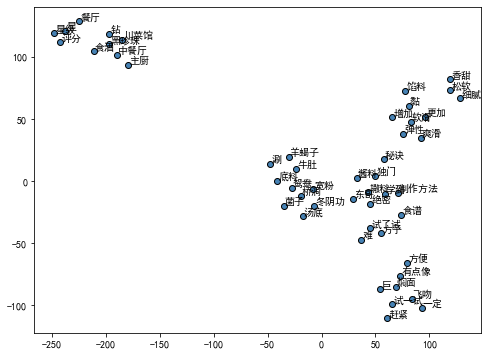

In [42]:
plot_tsne_2D(kw_similar_vectors_title[idx1_title] +  
             kw_similar_vectors_title[idx2_title] + 
             kw_similar_vectors_title[idx3_title] +  
             kw_similar_vectors_title[idx4_title] +  
             kw_similar_vectors_title[idx5_title],             
             kw_similar_list_title[idx1_title] +  
             kw_similar_list_title[idx2_title] + 
             kw_similar_list_title[idx3_title] +  
             kw_similar_list_title[idx4_title] +  
             kw_similar_list_title[idx5_title])

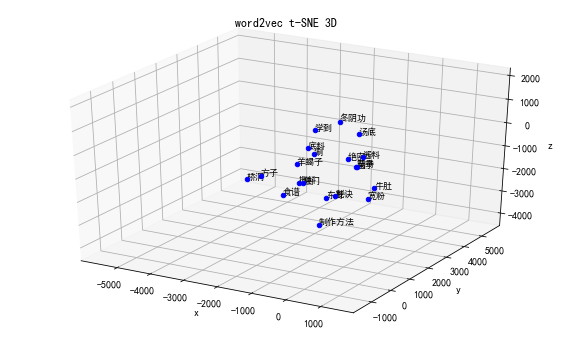

In [43]:
plot_tsne_3D(kw_similar_vectors_title[idx2_title] +  
             kw_similar_vectors_title[idx4_title],             
             kw_similar_list_title[idx2_title] +  
             kw_similar_list_title[idx4_title])

## Part 4 Transfer back to get features

###### Method 1: use keywords weights

In [72]:
print(kw_list_desc)
print('\n')
print(kw_list_title)

['淀粉', '可爱', '牛排', '教程', '陕西', '发现', '收藏', '宝宝', '酱汁', '博主', '不会', '味道', '视频', '东西', '排骨', '粉丝', '需要', '奶茶', '看看', '城市', '准备', '方法', '简单', '小龙虾', '简介', '地址', '黄油', '广州', '土豆', '自制', '素质', '快乐', '烤箱', '全网', '推荐', '番茄', '吃喝', '下酒菜', '已经', '老板', '加入', '喜欢', '口味', '鸡翅', '马蹄', '倒入', '炸鸡', '觉得', '下饭', '块钱', '一直', '有点', '小勺', '小伙', '传统', '秘制', '食材', '招募', '感觉', '早餐', '搭配', '终于', '欢迎', '牛奶', '小马', '料酒', '投币', '啤酒', '支持', '料理', '做成', '鼓励', '吃货', '分享', '美食', '泡面', '非常', '真的', '最大', '不能', '希望', '不用', '芝士', '试吃', '素材', '测评', '关注', '兄弟', '到底', '其实', '继续', '米饭', '专业', '喝酒', '面包', '火锅', '朋友', '饭菜', '面粉', '起来', '评论', '蛋糕', '蛋黄', '家常', '赶海', '日常', '鸡蛋', '胡椒粉', '牛肉', '一期', '奶油', '放入', '特别', '一定', '小吃', '小时', '比较', '更新', '频道', '时间', '小伙伴', '白糖', '吃饭', '完整', '动力', '感谢', '做法', '知道', '好吃', '厨房', '过瘾', '点赞', '配料', '配方', '口感', '公众', '适量', '软软', '餐厅', '中国', '拍摄', '烧烤', '海鲜', '外卖', '洋葱']


['神仙', '牛排', '披萨', '陕西', '发现', '收藏', '英国', '不会', '味道', '视频', '排骨', '小哥', '粉丝', '鸡腿', '厨师长', '简单', '小龙虾', '开箱', '广州', '学会', 

In [73]:
index_desc = [word in kw_list_desc for word in words_desc]
same_weights_desc = weights_desc[:,index_desc]
same_weights_desc.shape

(15372, 145)

In [74]:
index_title = [word in kw_list_title for word in words_title]
same_weights_title = weights_title[:,index_title]
same_weights_title.shape

(15372, 125)

###### Method 2: use similiar words

In [47]:
def transfer_similiar_weights(words, weights_all, kw_similar_list, keywords_same):
    similiar_weights = []
    keywords_same_list = list(keywords_same)
    for i in range(len(keywords_same_list)):
        index_similiar = [(word in kw_similar_list[i]) | (word in  keywords_same_list[i]) for word in words]
        weights = weights_all[:,index_similiar].sum(axis = 1)
        similiar_weights.append(weights)
    return np.array(similiar_weights).T

In [66]:
similiar_weights_desc = transfer_similiar_weights(words_desc, weights_desc, kw_similar_list_desc, kw_list_desc)

In [67]:
similiar_weights_title = transfer_similiar_weights(words_title, weights_title, kw_similar_list_title, kw_list_title)

###### Compare those two methods' outcomes
!!!!! Very Sparse !!!!!

In [75]:
pd.DataFrame(same_weights_desc, columns = kw_list_desc).quantile([0.95,0.97,0.99,0.999])

,淀粉,可爱,牛排,教程,陕西,发现,收藏,宝宝,酱汁,博主,...,公众,适量,软软,餐厅,中国,拍摄,烧烤,海鲜,外卖,洋葱
0.950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.075814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.990,0.163323,0.087196,0.110414,0.165228,0.000000,0.097171,0.000000,0.000000,0.00000,0.132721,...,0.163033,0.000000,0.188577,0.000000,0.162711,0.000000,0.000000,0.211536,0.097533,0.000000
0.999,0.402219,0.400740,0.286417,0.347338,0.370027,0.435230,0.339224,0.330221,0.38294,0.385180,...,0.392376,0.494955,0.338496,0.407764,0.279703,0.585317,0.488105,0.461030,0.379571,0.734329


In [69]:
pd.DataFrame(similiar_weights_desc, columns = kw_list_desc).quantile([0.95,0.97,0.99,0.999])

,淀粉,可爱,牛排,教程,陕西,发现,收藏,宝宝,酱汁,博主,...,公众,适量,软软,餐厅,中国,拍摄,烧烤,海鲜,外卖,洋葱
0.950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.255671,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.990,0.240895,0.108169,0.000000,0.268822,0.280437,0.251275,0.577106,0.178075,0.263725,0.000000,...,0.337468,0.260223,0.319657,0.195423,0.125082,0.229787,0.000000,0.256563,0.166274,0.277793
0.999,0.592283,1.000000,0.792857,1.012140,0.630448,0.587193,1.031851,1.000000,0.577565,0.785086,...,1.302856,0.755085,0.910421,0.644187,0.593164,0.640977,0.543107,0.655129,0.602802,0.642037


In [76]:
pd.DataFrame(same_weights_title, columns = kw_list_title).quantile([0.95,0.97,0.99,0.999])

,神仙,牛排,披萨,陕西,发现,收藏,英国,不会,味道,视频,...,过瘾,拌面,配方,口感,中国,餐厅,烧烤,海鲜,外卖,新疆
0.950,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
0.970,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
0.990,0.000000,0.227722,0.00000,0.210263,0.000000,0.188682,0.000000,0.000000,0.047043,0.254714,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.264283
0.999,0.412487,0.404966,0.43881,0.421040,0.412019,0.418722,0.434876,0.392947,0.450803,0.410629,...,0.516279,0.540725,0.48121,0.389888,0.417353,0.396641,0.370984,0.534,0.452578,0.561659


In [70]:
pd.DataFrame(similiar_weights_title, columns = kw_list_title).quantile([0.95,0.97,0.99,0.999])

,神仙,牛排,披萨,陕西,发现,收藏,英国,不会,味道,视频,...,过瘾,拌面,配方,口感,中国,餐厅,烧烤,海鲜,外卖,新疆
0.950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.197489,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256980,0.000000,...,0.236493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.990,0.000000,0.324728,0.369777,0.310112,0.285173,0.285933,0.323183,0.317137,0.376345,0.268878,...,0.361115,0.356410,0.345135,0.334190,0.280108,0.304718,0.284741,0.342870,0.307804,0.198008
0.999,0.647967,1.045916,0.894610,0.759522,0.566014,0.685158,0.815500,0.592848,0.610776,0.643054,...,0.658298,0.810552,0.750530,0.682383,0.658855,0.795783,0.770601,0.748652,0.672099,0.928648


## Part 5 Try to fit into model

#### process data and output

In [79]:
same_weights_desc_df = pd.DataFrame(same_weights_desc, columns = ('same_desc'+s for s in kw_list_desc))
similiar_weights_desc_df = pd.DataFrame(similiar_weights_desc, columns = ('similiar_desc'+s for s in kw_list_desc))

In [78]:
same_weights_title_df = pd.DataFrame(same_weights_title, columns = ('same_title'+s for s in kw_list_title))
similiar_weights_title_df = pd.DataFrame(similiar_weights_title, columns = ('similiar_title'+s for s in kw_list_title))

In [88]:
data_add_text = data
data_add_text = data_add_text.join(similiar_weights_desc_df)
data_add_text = data_add_text.join(similiar_weights_title_df)

In [111]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.options.display.width=None
data_add_text.head()

,美食,美食制作,生活,美食圈,日常,吃货,美食侦探,美食vlog,吃播,美食测评,搞笑,料理制作,厨艺,VLOG,制作教程,家常菜,美食视频,自制,生活记录,全能打卡挑战,daily,food,food_country,food_detect,food_eval,food_record,funny,aid,author,bvid,created,description,comment,follower,length,likes,play,title,typeid,video_review,top1,top1_count,top2,top2_count,top3,top3_count,count_sum,food_ratio,life_ratio,hour,day_time,weekday,is_weekend,last_3month_play,last_3month_count,log_play,similiar_desc淀粉,similiar_desc可爱,similiar_desc牛排,similiar_desc教程,similiar_desc陕西,similiar_desc发现,similiar_desc收藏,similiar_desc宝宝,similiar_desc酱汁,similiar_desc博主,similiar_desc不会,similiar_desc味道,similiar_desc视频,similiar_desc东西,similiar_desc排骨,similiar_desc粉丝,similiar_desc需要,similiar_desc奶茶,similiar_desc看看,similiar_desc城市,similiar_desc准备,similiar_desc方法,similiar_desc简单,similiar_desc小龙虾,similiar_desc简介,similiar_desc地址,similiar_desc黄油,similiar_desc广州,similiar_desc土豆,similiar_desc自制,similiar_desc素质,similiar_desc快乐,similiar_desc烤箱,similiar_desc全网,similiar_desc推荐,similiar_desc番茄,similiar_desc吃喝,similiar_desc下酒菜,similiar_desc已经,similiar_desc老板,similiar_desc加入,similiar_desc喜欢,similiar_desc口味,similiar_desc鸡翅,similiar_desc马蹄,similiar_desc倒入,similiar_desc炸鸡,similiar_desc觉得,similiar_desc下饭,similiar_desc块钱,similiar_desc一直,similiar_desc有点,similiar_desc小勺,similiar_desc小伙,similiar_desc传统,similiar_desc秘制,similiar_desc食材,similiar_desc招募,similiar_desc感觉,similiar_desc早餐,similiar_desc搭配,similiar_desc终于,similiar_desc欢迎,similiar_desc牛奶,similiar_desc小马,similiar_desc料酒,similiar_desc投币,similiar_desc啤酒,similiar_desc支持,similiar_desc料理,similiar_desc做成,similiar_desc鼓励,similiar_desc吃货,similiar_desc分享,similiar_desc美食,similiar_desc泡面,similiar_desc非常,similiar_desc真的,similiar_desc最大,similiar_desc不能,similiar_desc希望,similiar_desc不用,similiar_desc芝士,similiar_desc试吃,similiar_desc素材,similiar_desc测评,similiar_desc关注,similiar_desc兄弟,similiar_desc到底,similiar_desc其实,similiar_desc继续,similiar_desc米饭,similiar_desc专业,similiar_desc喝酒,similiar_desc面包,similiar_desc火锅,similiar_desc朋友,similiar_desc饭菜,similiar_desc面粉,similiar_desc起来,similiar_desc评论,similiar_desc蛋糕,similiar_desc蛋黄,similiar_desc家常,similiar_desc赶海,similiar_desc日常,similiar_desc鸡蛋,similiar_desc胡椒粉,similiar_desc牛肉,similiar_desc一期,similiar_desc奶油,similiar_desc放入,similiar_desc特别,similiar_desc一定,similiar_desc小吃,similiar_desc小时,similiar_desc比较,similiar_desc更新,similiar_desc频道,similiar_desc时间,similiar_desc小伙伴,similiar_desc白糖,similiar_desc吃饭,similiar_desc完整,similiar_desc动力,similiar_desc感谢,similiar_desc做法,similiar_desc知道,similiar_desc好吃,similiar_desc厨房,similiar_desc过瘾,similiar_desc点赞,similiar_desc配料,similiar_desc配方,similiar_desc口感,similiar_desc公众,similiar_desc适量,similiar_desc软软,similiar_desc餐厅,similiar_desc中国,similiar_desc拍摄,similiar_desc烧烤,similiar_desc海鲜,similiar_desc外卖,similiar_desc洋葱,similiar_title神仙,similiar_title牛排,similiar_title披萨,similiar_title陕西,similiar_title发现,similiar_title收藏,similiar_title英国,similiar_title不会,similiar_title味道,similiar_title视频,similiar_title排骨,similiar_title小哥,similiar_title粉丝,similiar_title鸡腿,similiar_title厨师长,similiar_title简单,similiar_title小龙虾,similiar_title开箱,similiar_title广州,similiar_title学会,similiar_title甜品,similiar_title土豆,similiar_title做出,similiar_title汉堡,similiar_title浓郁,similiar_title拉面,similiar_title自制,similiar_title米其林,similiar_title快乐,similiar_title全网,similiar_title零食,similiar_title番茄,similiar_title肥牛,similiar_title脆皮,similiar_title居然,similiar_title老板,similiar_title网红,similiar_title喜欢,similiar_title口味,similiar_title鸡翅,similiar_title开胃,similiar_title原来,similiar_title炸鸡,similiar_title品城,similiar_title治愈,similiar_title下饭,similiar_title块钱,similiar_title完美,similiar_title成功,similiar_title小伙,similiar_title传统,similiar_title吐司,similiar_title秘制,similiar_title食材,similiar_title感觉,similiar_title螺蛳,similiar_title早餐,similiar_title搭配,similiar_title五花肉,similiar_title终于,similiar_title牛奶,similiar_title烤肉,similiar_title体验,similiar_title料理,similiar_title做成,similiar_title吃货,similiar_title分享,similiar_title美食,similiar_title韩式,similiar_title泡面,similiar_title真的,similiar_title复刻,similiar_title鲜嫩,similiar_title可乐,similiar_

In [119]:
data_add_text.to_csv('data_v3_addtext.csv',index = 0)

#### Model

In [143]:
#import the decision tree module from sklearn
from sklearn.tree import DecisionTreeClassifier

#build a decision tree with max_depth = 20 using entropy
Y = data_text['video_review']
X = data_text.drop('video_review', 1)
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10)
dt.fit(X, Y)

#Now use built in feature importance attribute to get MI of each feature and Y
feature_mi = dt.feature_importances_

In [161]:
feature_mi_index = feature_mi.argsort()[::-1]
#Add features and their importances to a dictionary
feature_mi_dict = dict(zip(X.columns[feature_mi_index], feature_mi[feature_mi_index]))
feature_mi_dict

{'similiar_desc视频': 0.18181148410262257,
 'similiar_desc喜欢': 0.16117160339007494,
 'similiar_title味道': 0.11396404000999119,
 'similiar_desc味道': 0.07078249798816931,
 'similiar_title小伙': 0.053409947213759634,
 'similiar_desc希望': 0.04447477185327272,
 'similiar_desc支持': 0.043159995412891124,
 'similiar_title好吃': 0.03998570625963886,
 'similiar_desc美食': 0.037792444476008345,
 'similiar_desc关注': 0.029455961621546862,
 'similiar_desc好吃': 0.02727860412023269,
 'similiar_desc觉得': 0.021565809811118594,
 'similiar_desc一定': 0.016274930589563065,
 'similiar_title居然': 0.014687527172529616,
 'similiar_desc投币': 0.012307905299847067,
 'similiar_desc欢迎': 0.012279591351722805,
 'similiar_title感觉': 0.01212635253143891,
 'similiar_desc感谢': 0.011700922174944691,
 'similiar_desc知道': 0.010919682022473174,
 'similiar_desc感觉': 0.009364996673822198,
 'similiar_desc吃货': 0.008929046258955435,
 'similiar_desc收藏': 0.006547582595417189,
 'similiar_desc真的': 0.005456216125873517,
 'similiar_desc一期': 0.005413704910394

In [158]:
from sklearn.linear_model import Lasso

#Now use built in feature importance attribute to get MI of each feature and Y
lr = Lasso(normalize = True)
lr.fit(X, Y)

Lasso(normalize=True)

In [160]:
feature_lr = lr.coef_
feature_lr_index = np.abs(feature_lr).argsort()[::-1]
#Add features and their importances to a dictionary
feature_lr_dict = dict(zip(X.columns[feature_lr_index], feature_lr[feature_lr_index]))
feature_lr_dict

{'similiar_desc宝宝': 13082.79253585321,
 'similiar_title游戏': 12181.921268612177,
 'similiar_desc兄弟': 10882.09709151095,
 'similiar_desc更新': 8752.627328179618,
 'similiar_desc鼓励': 6486.247714619127,
 'similiar_desc料理': 6165.897103303161,
 'similiar_desc素质': 4505.628307976764,
 'similiar_title小伙': 3765.1354544647124,
 'similiar_title兄弟': 3338.184754954487,
 'similiar_desc感谢': 3230.5633610055515,
 'similiar_title世界': 2693.5845543615224,
 'similiar_title粉丝': 2549.1982108322113,
 'similiar_desc小伙': 1927.4608177391422,
 'similiar_title试吃': 1721.352378116297,
 'similiar_title简单': -1504.7504839025191,
 'similiar_title日本': 1464.9866823455488,
 'similiar_desc朋友': 1174.3249404738406,
 'similiar_desc配方': -1153.4040113446538,
 'similiar_desc做法': -740.9506856533267,
 'similiar_desc支持': 689.7108185248612,
 'similiar_desc收看': -671.6574350882704,
 'similiar_desc简单': -442.82361752154054,
 'similiar_desc频道': 395.55653564961375,
 'similiar_title入味': -269.5309333309908,
 'similiar_title学会': -267.82736368904

## Reference
[`NLP关键词提取方法总结及实现`](https://blog.csdn.net/asialee_bird/article/details/96454544)

[`jiaba关键词提取提速策略&基于word2vec的关键词提取方法&python中文编码问题&人人网的关键词提取策略`](https://www.jianshu.com/p/695eb0fd3745)

[`关键词抽取、Word2Vec词向量`](https://zhuanlan.zhihu.com/p/38162556)

[`“结巴”中文分词`](https://github.com/fxsjy/jieba)